<hr>

# Program plots profiles of state variables and process tendencies at various locations and times of ENSO phase

<ul>
<li> Level 1: Mean profiles of states and tendencies during ENSO phase (seasons: monthly means) </li>
<li> Level 2: Time varying profiles during a season or seasonal transtion </li>
<li> Level 3: Statistical reltiosnhips between vertical processes and ENSO/forcing/dynamical strength </li>
</ul>
<hr>

In [9]:
import numpy as np
import matplotlib.pyplot as mp
import xarray as xr
import datetime as dt
import cartopy.crs as ccrs
import pandas as pd

In [10]:
### To Import My Functions ###
import vert_proc_func as mypy
import importlib


# Initial Simulation Information

In [11]:

#case_desc = np.array(['C6','C5','rC5now','rUW','rUWp','rMG1','rC5p','rC5pm','rZMc','rZMp','rpfrac','rCE2i']) ; pref_out = 'revert'
case_desc = np.array(['C6','rC5','rUW']) ; pref_out = ''                      

#month_ave = np.array(["Jul","Aug","Sep","Oct","Nov"]) 
month_ave = np.array(["Jan","Feb","Dec"])

clim_anal = False

years_hist = [1979,1982] # Year range of history files to read.

dir_croot = '/glade/p/cgd/amp/people/hannay/amwg/climo/' # Directories with climo files
dir_hroot = '/glade/p/cgd/amp/amwg/runs/' # Run firectories with history files
dir_obs = '/glade/p/cesm/amwg/amwg_data/obs_data/'

## Variable description ##

var_name = 'ZMDT'

var_desc = {}

#var_names = ['OMEGA','DIV'] ; vscales = [1.,1] ; f1xmin=-0.14; f1xmax=0.02 ;f1dx = 0.02 ; f2xmin=-0.0005; f2xmax=0.0002 ;f2dx = 0.0002  ; f1name = '[Vertical Velocity [pa/s]]' ; f2name = '[Convergence [/s]]'
#var_scale =  100./86400.  # mb/day -> pa/s

var_desc['DTCOND'] = ['Total Moist Tendency',86400., -5.,5.]
var_desc['DCQ'] = ['Total Moist Tendency',86400., -5.,5.]
var_desc['ZMDT'] = ['Total Moist Tendency',86400., -5.,5.]

#var_names = ['ZMDQ','ZMDT'] ; vscales = [86400*1000,86400.] ; f1xmin=-5.; f1xmax=5. ;f1dx = 1. ; f2xmin=-8.; f2xmax=8. ;f2dx = 2.  ; f1name = '[Deep Convection Moistening [g/kg/day]]' ; f2name = '[Deep Convection Heating [K/day]]'
lobs = True

p_levs = np.arange(100.,1050.,50.)


######
sim_names = cam_revert_list()
#sim_names = cam_vres_list()




### Named Regions ###

reg_names = {}

reg_names['E Pac'] = ['East Pacific',7.5,10,220.,240] # ITCZ East Pacific
reg_names['W Pac'] = ['West Pacific',-5,5,120.,160] # Equatorial Warm Pool W. Pacific




## Specify data frames ##

reg_df = pd.DataFrame.from_dict(reg_names, orient='index',columns=['long_name','lat_s','lat_n','lon_w','lon_e'])
var_df = pd.DataFrame.from_dict(var_desc, orient='index',columns=['long_name','vscale','xmin','xmax'])


# Main Code
## Monthly Climatologies

-Averaging for months -  ['Jan' 'Feb' 'Dec']



**** CASE #  [1]  OF  3  ****
- Name =  C6  -> f.e20.FHIST.f09_f09.cesm2_1.001
  - Region =  East Pacific  -  7.5 10 220.0 240
-Averaging for region -  140-120°W 7.5-10°N
  - Region =  West Pacific  -  -5.0 5 120.0 160
-Averaging for region -  240-200°W -5.0-5°N


**** CASE #  [2]  OF  3  ****
- Name =  rC5  -> f.e20.FHIST.f09_f09.cesm2_1_true-cam5.001
  - Region =  East Pacific  -  7.5 10 220.0 240
-Averaging for region -  140-120°W 7.5-10°N
  - Region =  West Pacific  -  -5.0 5 120.0 160
-Averaging for region -  240-200°W -5.0-5°N


**** CASE #  [3]  OF  3  ****
- Name =  rUW  -> f.e20.FHIST.f09_f09.cesm2_1_uw.002
  - Region =  East Pacific  -  7.5 10 220.0 240
-Averaging for region -  140-120°W 7.5-10°N
  - Region =  West Pacific  -  -5.0 5 120.0 160
-Averaging for region -  240-200°W -5.0-5°N


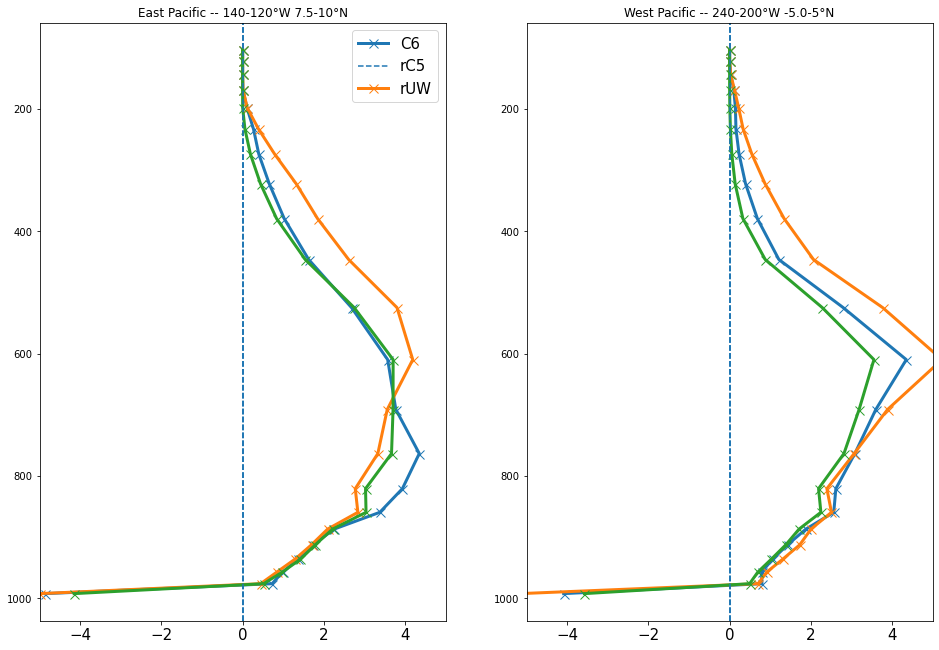

In [29]:
# Plan #

# - Seasonal Means - 
# - Cases -
# - Variables -
# 1. - Tendency Fields -
# 1. - Global fields -
# 1. - Global, vertical intergrals -
# 2. - Global PDFs (p levels)
# 3. - ENSO differences
# 3. - Dynamic Criteria (W500,PRECT)



nmnths = month_ave.size
ncases = case_desc.size
nregions = reg_df.index.size


## LOOP ##
fig, ax = mp.subplots(1,nregions,figsize=(16, 11))



print('-Averaging for months - ',month_ave)

print('')

#### Month numbering/concatonation ###
mnums = []

# Construct month strings
for im in range(0,nmnths): mnums.append(dt.datetime.strptime(month_ave[im], "%b").month)
mon_aves = [ "{:02}".format(x) for x in mnums ] # In correct format
mon_list = ','.join(mon_aves)


########################
##### LOOP CASES  ######
########################

for icase,case in enumerate(case_desc): # Do first so don't have to do a read mutliple times

    
# Grab run name 
    
    sim_name = sim_names.loc[case]['run name']
 
    
    print('')
    print('')
    print('**** CASE # ',[icase+1],' OF ',ncases,' ****')
    print('- Name = ',case,' ->',sim_name)
                    
## Read data in from files ##

# Changes pref. depending on case
    pre_dir = 'yrs_1979-2005' if case=='CE2' else '0.9x1.25'  

# Detemine files for input
    cfiles_in = [dir_croot+sim_name+'/'+pre_dir+'/'+sim_name+'_'+mon_aves[ff]+'_climo.nc' for ff in range(nmnths)]
    
# Point to files
    cfiles_ptr = xr.open_mfdataset(cfiles_in)
       
# Region independent fields 
    hyam = cfiles_ptr['hyam'] ; hybm = cfiles_ptr['hybm'] ; P0 = cfiles_ptr['P0'] ; lev = cfiles_ptr['lev']
    ilevs = np.where(lev >= min(p_levs))
    ilevs = ilevs[0]
    dp_lev = np.diff(lev)
    
# Variable read in and time averaging
    var_in = cfiles_ptr[var_name].mean(dim=['time'])

    

    
########################    
### Now Loop Regions ###
########################
    
    for ireg,reg in enumerate(reg_df.index):  ## 4 regions let's assume ##
       
## Assign lat/lon region domain
        reg_name = reg_df.loc[reg]['long_name'] 
    
        reg_s = reg_df.loc[reg]['lat_s'] ; reg_n = reg_df.loc[reg]['lat_n']
        reg_w = reg_df.loc[reg]['lon_w'] ; reg_e = reg_df.loc[reg]['lon_e']
        
        print('  - Region = ',reg_name,' - ',reg_s,reg_n,reg_w,reg_e)
                   
        reg_a_str = '%d-%d\u00b0W %.1f-%d\u00b0N' % (360-reg_w,360-reg_e,reg_s,reg_n)
        reg_a_out = '%d-%dW_%.1f-%dN' % (360-reg_w,360-reg_e,reg_s,reg_n)  
         
        
        print('-Averaging for region - ',reg_a_str)

## Scale, trim and average       
        var_plot = var_df.loc[var_name]['vscale']*var_in.loc[:,reg_s:reg_n,reg_w:reg_e]
        var_plot = var_plot.mean(dim=['lat','lon'])        
    
#:,reg_w:reg_e,reg_s:reg_n] 
       
             
        ax[ireg].plot(var_plot[ilevs],lev[ilevs],lw=3,markersize=9,marker='x')  
        ax[ireg].invert_yaxis()  
        ax[ireg].set_title(reg_name+' -- '+reg_a_str)
        ax[ireg].set_xlim([var_df.loc[var_name]['xmin'],var_df.loc[var_name]['xmax']])
        ax[ireg].axvline(0.,linestyle='--')
        

leg_cases = case_desc
mp.rcParams['xtick.labelsize']=15 # GLobal set of xtick label size    



ax[0].legend(leg_cases,fontsize=15)

    
#mp.savefig(pref_out+'_vprof_'+var_names[0]+'_'+var_names[1]+'_'+reg_a_out+'_'+month_ave[0]+'_to_'+month_ave[nmnths-1]+'.png', dpi=150)
#mp.show()

# ENSO Phase Compositing of Tendencies 
- Read in hist timeseries
- Calculate SST nino timeseries
- Composites based on season for vertical profiles
- Composites vertical profiles minus climo.


case =  C6
/glade/p/cgd/amp/amwg/runs/f.e20.FHIST.f09_f09.cesm2_1.001/atm/hist/f.e20.FHIST.f09_f09.cesm2_1.001.cam.h0.1979-01.nc
/glade/p/cgd/amp/amwg/runs/f.e20.FHIST.f09_f09.cesm2_1.001/atm/hist/f.e20.FHIST.f09_f09.cesm2_1.001.cam.h0.1982-12.nc
CPU times: user 13.5 s, sys: 42.9 ms, total: 13.5 s
Wall time: 15.7 s
<xarray.DataArray 'strftime' (time: 48)>
array(['Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct',
       'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul',
       'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr',
       'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan',
       'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct',
       'Nov', 'Dec', 'Jan'], dtype=object)
Coordinates:
  * time     (time) object 1979-02-01 00:00:00 ... 1983-01-01 00:00:00


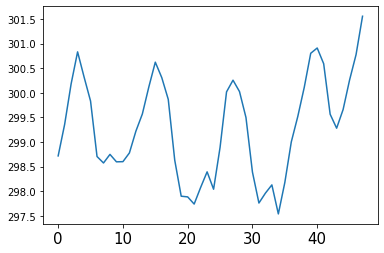


case =  rC5
/glade/p/cgd/amp/amwg/runs/f.e20.FHIST.f09_f09.cesm2_1_true-cam5.001/atm/hist/f.e20.FHIST.f09_f09.cesm2_1_true-cam5.001.cam.h0.1979-01.nc
/glade/p/cgd/amp/amwg/runs/f.e20.FHIST.f09_f09.cesm2_1_true-cam5.001/atm/hist/f.e20.FHIST.f09_f09.cesm2_1_true-cam5.001.cam.h0.1982-12.nc
CPU times: user 11.8 s, sys: 66 ms, total: 11.9 s
Wall time: 13.7 s
<xarray.DataArray 'strftime' (time: 48)>
array(['Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct',
       'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul',
       'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr',
       'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan',
       'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct',
       'Nov', 'Dec', 'Jan'], dtype=object)
Coordinates:
  * time     (time) object 1979-02-01 00:00:00 ... 1983-01-01 00:00:00


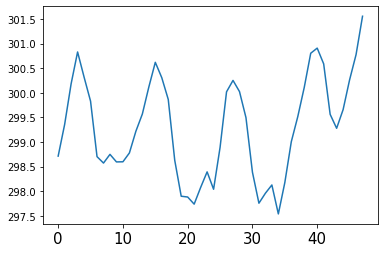


case =  rUW
/glade/p/cgd/amp/amwg/runs/f.e20.FHIST.f09_f09.cesm2_1_uw.002/atm/hist/f.e20.FHIST.f09_f09.cesm2_1_uw.002.cam.h0.1979-01.nc
/glade/p/cgd/amp/amwg/runs/f.e20.FHIST.f09_f09.cesm2_1_uw.002/atm/hist/f.e20.FHIST.f09_f09.cesm2_1_uw.002.cam.h0.1982-12.nc
CPU times: user 13 s, sys: 89 ms, total: 13.1 s
Wall time: 15.3 s
<xarray.DataArray 'strftime' (time: 48)>
array(['Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct',
       'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul',
       'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr',
       'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan',
       'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct',
       'Nov', 'Dec', 'Jan'], dtype=object)
Coordinates:
  * time     (time) object 1979-02-01 00:00:00 ... 1983-01-01 00:00:00


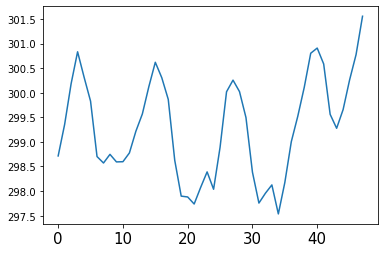

In [34]:
importlib.reload(mypy) # Required because I am constantly editing scam_func.py

### Read in history monthly mean files and composite profiles for tendencies###
dir_hroot = '/glade/p/cgd/amp/amwg/runs/'

#### Read in Data ####

yr0 = years_hist[0]
yr1 = years_hist[1]

########################
##### LOOP CASES  ######
########################

for icase,case in enumerate(case_desc): # Do first so don't have to do a read mutliple times

    sim_name = sim_names.loc[case]['run name']
    
# Construct requried history file month-year array

    hist_myr = np.array([".cam.h0.%d-%02d.nc"%(y, m) for y in range(yr0,yr1+1) for m in range(1,12+1)])
    num_h0 = hist_myr.size
  
    print('')
    print('case = ',case)
    
# Determine files for input
    hfiles_in = [dir_hroot+sim_name+'/atm/hist/'+sim_name+hist_myr[ff] for ff in range(num_h0)]
    print(hfiles_in[0])
    print(hfiles_in[-1])
    
# Point to files 
    # Point to files
    %time hfiles_ptr = xr.open_mfdataset(hfiles_in)

    nino_stats = mypy.nino_sst_anom(hfiles_ptr,'nino3')





In [32]:
#####################################
# CAM6 Revert Experiments + others   
#####################################


def cam_revert_list():
	

    rl = {} # Revert List
# Releases
    rl['C4']   =  ['f40.1979_amip.track1.1deg.001']
    rl['C5']   =  ['30L_cam5301_FAMIP.001']
    rl['C6']   =  ['f.e20.FHIST.f09_f09.cesm2_1.001']
    rl['CC4']  =  ['b40.20th.track1.1deg.012']
    rl['CE1']  =  ['b.e11.B20TRC5CNBDRD.f09_g16.001']
    rl['CE2']  =  ['b.e21.BHIST.f09_g17.CMIP6-historical.001']

    # Reverts
    rl['rC5now']  =   ['f.e20.FHIST.f09_f09.cesm2_1_cam5.001']
    rl['rC5']     =   ['f.e20.FHIST.f09_f09.cesm2_1_true-cam5.001']
    rl['rC5t']    =   ['f.e20.FHIST.f09_f09.cesm2_1_true-cam5_param_topo.001']
    rl['rUWold']  =   ['f.e20.FHIST.f09_f09.cesm2_1_uw.001']
    rl['rGW']    =   ['f.e20.FHIST.f09_f09.cesm2_1_iogw.001']
    rl['rZMc']  =   ['f.e20.FHIST.f09_f09.cesm2_1_capeten.001']
    rl['rMG1']  =   ['f.e20.FHIST.f09_f09.cesm2_1_mg1.001']
    rl['rSB']  =   ['f.e20.FHIST.f09_f09.cesm2_1_sb.002']
    rl['rTMS']  =   ['f.e20.FHIST.f09_f09.cesm2_1_tms.001']
    rl['rCE2i']  =   ['f.e20.FHIST.f09_f09.cesm2_1_revert125.001']
    rl['rC5p']  =   ['f.e20.FHIST.f09_f09.cesm2_1_revertcam5param.001']
    rl['rC5pm']  =   ['f.e20.FHIST.f09_f09.cesm2_1_revertcam5param.002']
    rl['rZMp']  =   ['f.e20.FHIST.f09_f09.cesm2_1_cam5_zmconv.001']
    rl['rM3']  =   ['f.e20.FHIST.f09_f09.cesm2_1_mam3.001']
    rl['rUW']  =   ['f.e20.FHIST.f09_f09.cesm2_1_uw.002']
    rl['rUWp']  =   ['f.e20.FHIST.f09_f09.cesm2_1_uw.003']
    rl['rMG1ii']  =   ['f.e20.FHIST.f09_f09.cesm2_1_mg1.002']
    rl['rice']  =   ['f.e20.FHIST.f09_f09.cesm2_1_ice-micro.001']
    rl['rpfrac']  =   ['f.e20.FHIST.f09_f09.cesm2_1_precip_frac_method.001']
    rl['rpremit']  =   ['f.e20.FHIST.f09_f09.cesm2_1_cld_premit.001']
    rl['rC5psalt']  =   ['f.e20.FHIST.f09_f09.cesm2_1_revertc5seasalt.001']
    rl['rC5pdust']  =   ['f.e20.FHIST.f09_f09.cesm2_1_revertc5dust.001']
    rl['rL30']  =   ['f.e20.FHIST.f09_f09.cesm2_1_L30.001']
    
# SST configs    
    rl['CE2sst']  =   ['f.e20.FHIST.f09_f09.cesm2_1_coupled-sst-amip.001']
    rl['CE2sstd']  =   ['f.e20.FHIST.f09_f09.cesm2_1_coupled-sst-amip_daily.001']
    rl['REYsstd']  =   ['f.e20.FHIST.f09_f09.cesm2_1_reynolds_daily_sst.006']

    
# High vertical resolution.
    rl['W110']  =   ['f.e21.FWscHIST_BCG.f09_f09_mg17_110L.001']
    rl['W121']  =   ['f.e21.FWscHIST_BCG.f09_f09_mg17_121L_DZ_400m_80kmTop.001']

# Data frame
    rl_df = pd.DataFrame.from_dict(rl, orient='index',columns=['run name'])
    return rl_df

In [8]:

def cam_vres_list():
	

    rl = {} # Revert List
# BL Vres
    rl['C5']   =  ['30L_cam5301_FAMIP.001']
    rl['C6']   =  ['f.e20.FHIST.f09_f09.cesm2_1.001']
    rl['L48']       =  ['f.e21.FWscHIST_BGC.ne30_ne30_mg17_L48_revert-J.001']
    rl['L48cin5']   =  ['f.e21.FWscHIST_BGC.ne30_ne30_mg17_L48_revert-J_num_cin-5.001']
    rl['L110'] = ['f.e21.FWscHIST_BCG.f09_f09_mg17_110L.001']


# Data frame
    rl_df = pd.DataFrame.from_dict(rl, orient='index',columns=['run name'])
    return rl_df